✅ Step 1: Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


✅ Step 2: Load Dataset and Prepare Filenames

In [2]:
# Load dataset
df = pd.read_csv("train.csv")

# Clean filename from URL
df['img_filename'] = df['url'].astype(str).apply(lambda x: os.path.basename(x.split('?')[0]))


 Step 3: Download Valid Images

In [3]:
os.makedirs("images", exist_ok=True)
valid_filenames = []

for idx, row in df.iterrows():
    filename = row['img_filename']
    url = row['url']
    path = os.path.join("images", filename)

    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content))
        img.convert("RGB").save(path)
        valid_filenames.append(filename)
    except Exception as e:
        print(f"Failed to download or process image: {filename} | {e}")


Failed to download or process image: trump-truth-social-djt-tesla-musk-tariffs-pause-fccfa6b06c8f1ec0cd7844641ca52669 | cannot identify image file <_io.BytesIO object at 0x7a0eb6b3cb30>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb668c9f0>
Failed to download or process image: index.html | cannot identify image file <_io.BytesIO object at 0x7a0eb66559e0>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb727b790>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb6654ef0>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb6b13470>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb727b790>
Failed to download or process image:  | cannot identify image file <_io.BytesIO object at 0x7a0eb7da6890>
Failed to download or process image:  | cannot identify image 

Filter DataFrame to Only Valid Images
python
Copy
Edit


In [4]:
df = df[df['img_filename'].isin(valid_filenames)].reset_index(drop=True)


Load Valid Image Arrays

In [5]:
image_arrays = []
for filename in df['img_filename']:
    try:
        img = load_img(os.path.join("images", filename), target_size=(64, 64))
        arr = img_to_array(img) / 255.0
        image_arrays.append(arr)
    except Exception as e:
        print(f"Error loading {filename}: {e}")

image_arrays = np.array(image_arrays)
labels = df['sentiment'].values  # This is what we want to predict


✅ Step 6: Confirm Data Consistency

In [6]:
print("Images:", len(image_arrays))
print("Labels:", len(labels))


Images: 263
Labels: 263


 Step 7: Build and Train CNN Model

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Regression output for sentiment
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

X_train, X_val, y_train, y_val = train_test_split(image_arrays, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 5.5132 - mae: 1.5546 - val_loss: 0.5291 - val_mae: 0.6256
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.7291 - mae: 0.7322 - val_loss: 0.5902 - val_mae: 0.6217
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.6485 - mae: 0.6760 - val_loss: 0.5769 - val_mae: 0.6147
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.6671 - mae: 0.6938 - val_loss: 0.5741 - val_mae: 0.6191
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.6178 - mae: 0.6471 - val_loss: 0.5837 - val_mae: 0.6168
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - loss: 0.6089 - mae: 0.6413 - val_loss: 0.5686 - val_mae: 0.6205
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.6014 - mae: 0.6320 - val_loss: 0.5797 - val_mae: 0.6133
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.6611 - mae: 0.6820 - val_loss: 0.5762 - val_mae: 0.6153
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0

 Step 8: Predict Sentiment from Images

In [8]:
predicted_sentiments = model.predict(image_arrays).flatten()
df['img_sentiment_score'] = predicted_sentiments


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Step 9: Save Final DataFrame

In [9]:
df.to_csv("train_with_img_sentiment.csv", index=False)


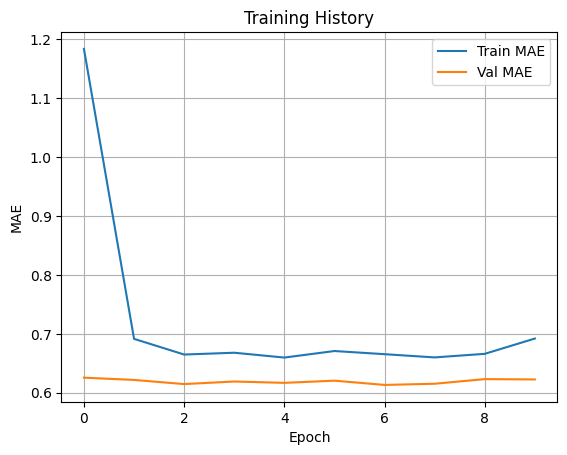

In [10]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training History")
plt.legend()
plt.grid(True)
plt.show()


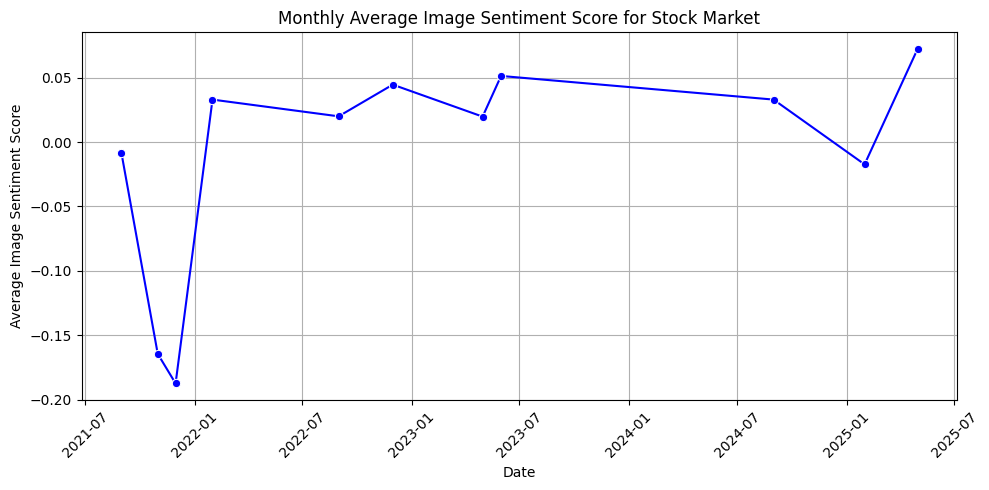

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('train_with_img_sentiment.csv')

# Convert 'datetime' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['datetime'])

# Optional: Filter for Stock Market subreddit if applicable
if 'subreddit' in df.columns:
    df = df[df['subreddit'].str.lower().str.contains('stock')]

# Resample: Monthly End average image sentiment score
df_time = df.set_index('datetime').resample('ME')['img_sentiment_score'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='datetime', y='img_sentiment_score', data=df_time, marker='o', color='blue')
plt.title('Monthly Average Image Sentiment Score for Stock Market')
plt.xlabel('Date')
plt.ylabel('Average Image Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

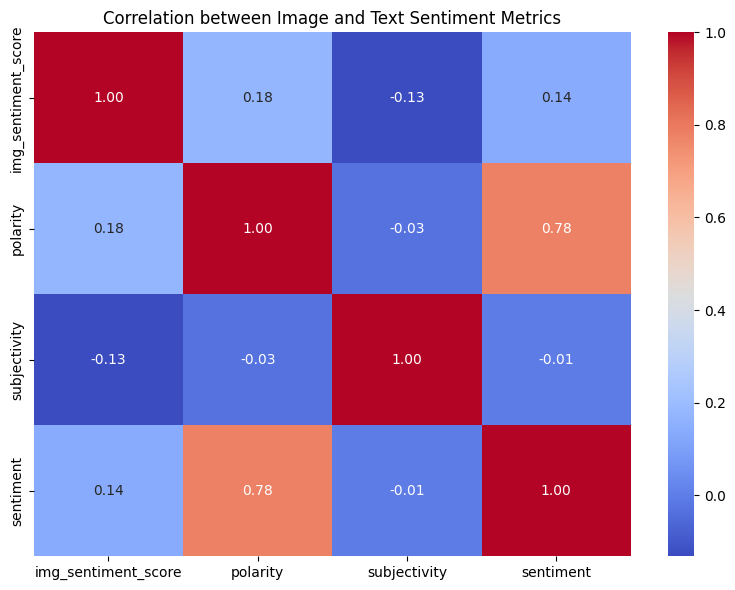

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("train_with_img_sentiment.csv")

# Select relevant numeric columns
correlation_data = df[['img_sentiment_score', 'polarity', 'subjectivity', 'sentiment']]

# Drop missing values if any
correlation_data = correlation_data.dropna()

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Image and Text Sentiment Metrics")
plt.tight_layout()
plt.show()
